# Statistical convergence speed analysis

This notebook assumes the user is in his own machine. It generates the run data and carry a basic statistical analysis of the results.

**Change this if necessary:**

In [ ]:
USER = "st76i1_5"
GROUP = "st76i1"
PASSWORD = input('Password: ')

In [ ]:
import sys
sys.path.append('/home/viniciustmoraes/Desktop/ST7Project/propagation-code-optimization') # change this

### Generate runs

In [ ]:
# make upload
!sshpass -p {PASSWORD} \
    scp -r ../../optimizer/ {USER}@chome.metz.supelec.fr:/usr/users/{GROUP}/{USER}/


In [ ]:
# Defines the number of times an algorithm is repeated for statistical analysis
n_stat = int(input('Number of simulations for statistical analysis: '))          

# run algorithm on cluster
runs = [
    "--algorithm hill_climbing --steps 100",
    "--algorithm greedy --steps 10",
    "--algorithm tabu_greedy --steps 10 --hparams '{\"n_tabu\":5}'",
    "--algorithm simulated_annealing --steps 100 --hparams '{\"t0\":20}'",
    "--algorithm csa --steps 100",
    "--algorithm cmaes --steps 100",
]

repeated_runs = []

for i in runs:
    repeated_runs += [i]*n_stat



In [ ]:

import pexpect

child = pexpect.spawn(f"sshpass -p {PASSWORD} \
                      ssh -tt {USER}@chome.metz.supelec.fr \
                      srun -p cpu_tp -N 1 -n 32 --pty bash",
                      timeout=5*60)

prompt = f"{USER}@kyle[0-9]+:"

for i in range(len(repeated_runs)):
    occupied = child.expect([prompt, "srun: job [1-9]+ queued and waiting for resources"])

    if occupied == 0:
        cmd = f"python3 -m optimizer.main {repeated_runs[i]} --log convergence_alg{i//n_stat}_run{i%n_stat}.log"
        child.sendline(cmd)
        running = 1
        while running == 1:
            running = child.expect(['Run finished', '\n'])
            output = child.before.decode()
            print(output)
        output = child.after.decode()
        print(output)

    elif occupied == 1:
        raise Exception("Error: no resource available. Try running `mysrun` and `scancel` on the remote machine.")
    
child.close()


In [ ]:
# make get_logs
!mkdir -p tmp/
!sshpass -p {PASSWORD} \
    scp '{USER}@chome.metz.supelec.fr:/usr/users/{GROUP}/{USER}/convergence_alg*.log' ./tmp/

### Convert logs to data

In [ ]:
from optimizer.logger import log_to_list
import numpy as np

data = {}
alg_to_name = {0:'hillclimbing', 1:'greedy', 2:'tabu', 3:'simulated_annealing', 4:'csa', 5:"CMAES"}

for i in range(n_stat*(len(runs))):
    alg = i//(len(runs)-1)
    run = i%(len(runs)-1)

    alg_name = alg_to_name[alg]
    
    data[alg_name+str(run)] = log_to_list(f'tmp/convergence_alg{alg}_run{run}.log')


### Extracting Data

In [ ]:
# Extract data with flairs (either Initial or New best) -> Hill Climbing and Simulated Annealing
new_data = {}

for i in range(n_stat):
    new_data[f'hillclimbing{i}'] = []
    new_data[f'simulated_annealing{i}'] = []

for key in data:
    if 'hillclimbing' in key or 'simulated_annealing' in key:
        for line in data[key]:
            if 'flair' in line:
                new_data[key].append(line)
    else:
        new_data[key] = data[key]
                
# Starts x and y variables for all the algorithms 

x0,y0 = [],[]
x1,y1 = [],[]
x2,y2 = [],[]
x3,y3 = [],[]
x4,y4 = [],[]
x5,y5 = [],[]

# For each iteration of each algorithm, writes the x (Nmbr of evaluations) and y (cost function) values

for k in range(n_stat):
    y0.append([float(new_data[f'hillclimbing{k}'][i]['Cost']) for i in range(0, len(new_data[f'hillclimbing{k}']))])
    x0.append([float(new_data[f'hillclimbing{k}'][i]['eval']) for i in range(0, len(new_data[f'hillclimbing{k}']))])

    y1.append([float(new_data[f'greedy{k}'][i]['Cost']) for i in range(0, len(new_data[f'greedy{k}']))])
    x1.append([float(new_data[f'greedy{k}'][i]['eval']) for i in range(0, len(new_data[f'greedy{k}']))])

    y2.append([float(new_data[f'tabu{k}'][i]['Cost']) for i in range(0, len(new_data[f'tabu{k}']))])
    x2.append([float(new_data[f'tabu{k}'][i]['eval']) for i in range(0, len(new_data[f'tabu{k}']))])

    y3.append([float(new_data[f'simulated_annealing{k}'][i]['Cost']) for i in range(0, len(new_data[f'simulated_annealing{k}']))])
    x3.append([float(new_data[f'simulated_annealing{k}'][i]['eval']) for i in range(0, len(new_data[f'simulated_annealing{k}']))])

    y4.append([float(new_data[f'csa{k}'][i]['Cost']) for i in range(0, len(new_data[f'csa{k}']))])
    x4.append([float(new_data[f'csa{k}'][i]['eval']) for i in range(0, len(new_data[f'csa{k}']))])

### Statistical Treatement

In [ ]:
interpolation = 'linear' #linear | quadratic | cubic ... 

from scipy.interpolate import interp1d
import numpy as np

final_results = []

values = [[x0,y0],[x1,y1],[x2,y2],[x3,y3],[x4,y4]]


for (x_list,y_list) in values:    
    # Determines which are the first and last limiting values for x, among the different runs
    last_eval = min([max(x_list[i]) for i in range(len(x_list))])    
    first_eval = max([min(x_list[i]) for i in range(len(x_list))])

    # Define the common set of x values
    x_common = np.arange(first_eval, last_eval+1)

    # Initialize an array to store the interpolated y values
    y_interp = np.zeros((len(x_common), n_stat))


    for i in range(n_stat):
        # Get the x and y values for the i-th run
        
        x = x_list[i][:]
        y = y_list[i][:]


        # Truncate the x and y values at the maximum number of evaluations
        x_trunc,y_trunc = [],[]
        for index in range(len(x)):
            if x[index] <= last_eval:
                x_trunc.append(x[index])
                y_trunc.append(y[index])


        # Interpolate the y values onto the common set of x values
        f = interp1d(x_trunc, y_trunc, kind=interpolation,fill_value="extrapolate")
        y_interp[:, i] = f(x_common)


    # Calculate the mean and standard deviation of the interpolated y values
    y_mean = np.mean(y_interp, axis=1)
    y_std = np.std(y_interp, axis=1)

    final_results.append([x_common, y_mean, y_std])



### Convergence speed comparison per number of evaluations

Text(0.5, 1.0, 'Algorithm Comparison for n = 5')

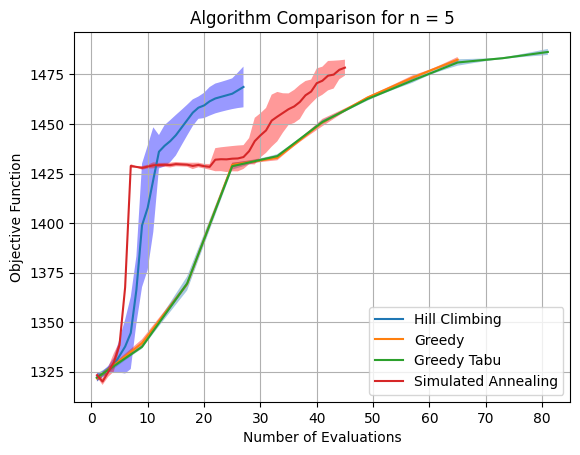

In [248]:
from matplotlib import pyplot as plt


# Hill Climbing
i = 0
x_0 = final_results[i][0]
mu_0 = final_results[i][1]
error_0 = final_results[i][2]
plt.fill_between(x_0, mu_0 - error_0, mu_0 + error_0,facecolor='blue', alpha = 0.4)
plt.plot(x_0,mu_0,label = 'Hill Climbing')

# Greedy
i = 1
x_1 = final_results[i][0]
mu_1 = final_results[i][1]
error_1 = final_results[i][2]
plt.fill_between(x_1, mu_1 - error_1, mu_1 + error_1,facecolor=(1,0,0,.4))
plt.plot(x_1,mu_1,label = 'Greedy')

# Greedy Tabu
i = 2
x_2 = final_results[i][0]
mu_2 = final_results[i][1]
error_2 = final_results[i][2]
plt.fill_between(x_2, mu_2 - error_2, mu_2 + error_2,alpha = 0.4)
plt.plot(x_2,mu_2,label = 'Greedy Tabu')

# Simulated Annealing
i = 3
x_3 = final_results[i][0]
mu_3 = final_results[i][1]
error_3 = final_results[i][2]
plt.fill_between(x_3, mu_3 - error_3, mu_3 + error_3,facecolor='red',alpha = 0.4)
plt.plot(x_3,mu_3,label = 'Simulated Annealing')

# CSA
i = 4
x_4 = final_results[i][0]
mu_4 = final_results[i][1]
error_4 = final_results[i][2]
#plt.fill_between(x_4, mu_4 - error_4, mu_4 + error_4,alha = 0.4)
#plt.plot(x_4,mu_4,label = 'CSA')

plt.grid()
plt.legend()
plt.xlabel('Number of Evaluations')
plt.ylabel('Objective Function')
plt.title(f'Algorithm Comparison for n = {n_stat}')

In [ ]:
from matplotlib import pyplot as plt

plt.plot(x0, y0, label='Hill Climbing')
plt.plot(x1, y1, label='Greedy Hill Climbing')
plt.plot(x2, y2, label='Tabu-Greedy Hill Climbing')
plt.plot(x3, y3, label='Simulated Annealing')
plt.legend()
plt.xlabel("No. of evaluations")
plt.ylabel("Cost (throughput)")
plt.title("Algorithm convergence speed comparison")
plt.grid()